In [64]:
import knn as knn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score


In [65]:
df=pd.read_csv('fruits/fruits.csv', sep=',')
display(df.head())
print("data shape:", df.shape)
print("\n" + "*"*15+"descriptive statistics"+"*"*15)
display(df.describe().round(2))
predct = dict(zip(df.fruit_label.unique(), df.fruit_name.unique()))   
print("\nlabel mapping: ", predct)
print("\ncount label occurance: ")
df['fruit_name'].value_counts()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


data shape: (59, 7)

***************descriptive statistics***************


,fruit_label,mass,width,height,color_score
count,59.00,59.00,59.00,59.00,59.00
mean,2.54,163.12,7.11,7.69,0.76
std,1.21,55.02,0.82,1.36,0.08
min,1.00,76.00,5.80,4.00,0.55
25%,1.00,140.00,6.60,7.20,0.72
50%,3.00,158.00,7.20,7.60,0.75
75%,4.00,177.00,7.50,8.20,0.81
max,4.00,362.00,9.60,10.50,0.93



label mapping:  {1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

count label occurance: 


apple       19
orange      19
lemon       16
mandarin     5
Name: fruit_name, dtype: int64

In [66]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# fig, ax = plt.subplots(1,1, figsize=(10,8))
# sns.heatmap(corr, annot = True, fmt ='.1g', ax = ax)

,fruit_label,mass,width,height,color_score
fruit_label,1.00,0.03,-0.30,0.51,-0.31
mass,0.03,1.00,0.88,0.61,-0.08
width,-0.30,0.88,1.00,0.40,-0.08
height,0.51,0.61,0.40,1.00,-0.25
color_score,-0.31,-0.08,-0.08,-0.25,1.00


Data normalization

In [67]:
dff = df[['mass','width','height', 'color_score']]
dataf=((dff-dff.min())/(dff.max()-dff.min()))
display(dataf.describe().round(2))
dataf['fruit_label'] = df['fruit_label']

,mass,width,height,color_score
count,59.00,59.00,59.00,59.00
mean,0.30,0.34,0.57,0.56
std,0.19,0.21,0.21,0.20
min,0.00,0.00,0.00,0.00
25%,0.22,0.21,0.49,0.45
50%,0.29,0.37,0.55,0.53
75%,0.35,0.45,0.65,0.68
max,1.00,1.00,1.00,1.00


In [68]:
data = dataf.to_numpy()
X,y = data[:, :-1], data[:,-1]
print("features shape:", X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
unique, counts = np.unique(y_train, return_counts=True)
print("Training label occurance: ", dict(zip(map(int,unique), counts)))

features shape: (59, 4)
Training data shape: (39, 4)
Testing data shape: (20, 4)
Training label occurance:  {1: 12, 2: 3, 3: 13, 4: 11}


## Data Spliting

### Model A

In [69]:
%%time
%%capture
numFolds = 5
kA = [k+1 for k in range(20)]
scoresA = []
for k in kA: 
    scoresA.append(knn.kFCVEvaluateA(X_train, y_train, k,numFolds))

CPU times: user 130 ms, sys: 15.6 ms, total: 146 ms
Wall time: 155 ms


In [70]:
%%time
%%capture A2
numFolds = len(X_train)
kA = [k+1 for k in range(20)]
scoresA2 = []
for k in kA: 
    scoresA2.append(knn.kFCVEvaluateA(X_train, y_train, k,numFolds))

CPU times: user 300 ms, sys: 6.19 ms, total: 307 ms
Wall time: 309 ms


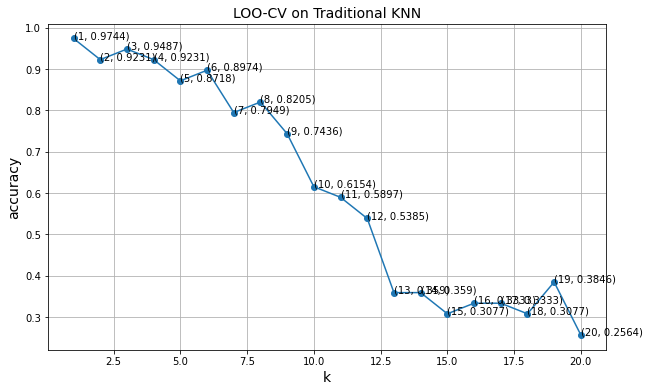

In [71]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

# ax[0].plot(kA,scoresA, marker='o', markersize=6)
# for (x,y) in zip(kA,scoresA):
#     ax[0].annotate('(%s, %s)' % (x, round(y,4)), xy=(x, y), textcoords='data') 
# ax[0].set_xlabel('k')
# ax[0].set_ylabel('accuracy')
# ax[0].set_title('5-folds CV')
# ax[0].grid()

ax.plot(kA,scoresA2, marker='o', markersize=6)
for (x,y) in zip(kA,scoresA2):
    ax.annotate('(%s, %s)' % (x, round(y,4)), xy=(x, y), textcoords='data') 
ax.set_xlabel('k', fontsize = 14)
ax.set_ylabel('accuracy', fontsize = 14)
ax.set_title('LOO-CV on Traditional KNN', fontsize = 14)
plt.grid()
plt.show()

In [72]:
NA80 = int(len(X_train)*0.8)
NB80 = len(X_train)-NA80
NA50 = int(len(X_train)*0.5)
NB50 = len(X_train)-NA50
print(NA80, NB80, NA50, NB50)

31 8 19 20


In [73]:
def perB(perA, k1B, k2B):
    scoresB1 = []
    maxscore = 0
    for k2 in k2B: 
        score = []
        for k1 in k1B:
            s = knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds)
            score.append(knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds))
            if s > maxscore:
                maxscore = s
                k1max, k2max = k1, k2
        scoresB1.append(score)
    return max(map(max, scoresB1)), k1max, k2max
def perC(N_A, N_B, perA, k1B, k2B):
    scoresC = []
    maxscore = 0
    for k2 in k2B: 
        score = []
        for k1 in k1B:
            coef = ((N_B*k1)/(N_A*k2))**(2/d)
            s = knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds, coef = coef)
            score.append(s)
            if s > maxscore:
                maxscore = s
                k1max, k2max = k1, k2
        scoresC.append(score)
    return max(map(max, scoresC)), k1max, k2max

## 80% labelled

### Model B

In [52]:
%%time 
numFolds = len(X_train)
perA = np.linspace(0.03,1,100)
k1B, k2B = [k+1 for k in range(20)], [k+1 for k in range(8)]
maxScoresB = []
klistB = dict()
for p in perA:
    scoreB, k1b, k2b = perB(p, k1B, k2B)
    if scoreB in klist:
        klistB[scoreB].append({"labelled\%": p, "k1": k1b, "k2": k2b})
    else: klistB[scoreB]=[{"labelled\%": p,"k1": k1b, "k2": k2b}]
    maxScoresB.append(scoreB)

KeyError: 0.3333333333333333

### Model C

In [43]:
%%time 
numFolds = len(X_train)
d = 4
perA = np.linspace(0.03,1,100)
k1B, k2B = [k+1 for k in range(20)], [k+1 for k in range(8)]
maxScoresC = []
klist = dict()
for p in perA:
    N_A = int(len(X_train)* p)
    N_B = len(X_train) - N_A
    scoreC, k1c, k2c = perC(N_A, N_B, p, k1B, k2B)
    
    if scoreC in klist:
        klist[scoreC].append({"per:": p, "k1": k1c, "k2": k2c})
    else: klist[scoreC]=[{"per:": p, "k1": k1c, "k2": k2c}]
    maxScoresC.append(scoreC)

CPU times: user 16min 32s, sys: 2.94 s, total: 16min 35s
Wall time: 16min 39s


In [63]:
dfc = pd.DataFrame(klist[1.0])
dfc["per:"] = round(dfc["per:"],4)
dfc = dfc.rename(columns={"per:":"labelled%"})
display(dfc.sort_values(["k1", "k2", 'labelled%']))
dfc.groupby("k2").mean()

,labelled%,k1,k2
6,0.7355,1,1
9,0.8138,1,1
11,0.8334,1,1
20,0.9706,1,1
5,0.6865,1,2
14,0.8726,1,2
17,0.9020,1,2
19,0.9314,1,2
2,0.6473,1,3
0,0.4905,1,5


,labelled%,k1
k2,,
1,0.838325,1.0
2,0.848125,1.0
3,0.769750,1.5
5,0.539500,1.0
6,0.768760,1.0
7,0.855450,1.0


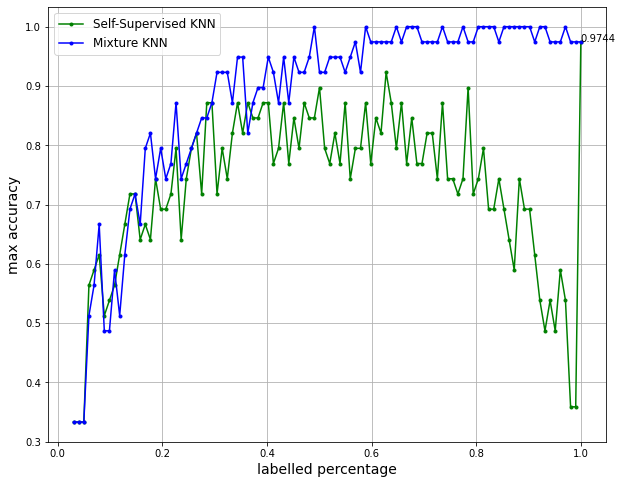

In [48]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.plot(perA,maxScoresB, marker='o', markersize=3, color='green', label='Self-Supervised KNN')
ax.plot(perA,maxScoresC, marker='o', markersize=3, color='blue', label='Mixture KNN')
# ax.plot(perA,[1]*len(perA), color='red')
ax.annotate('%s' % (round(maxScoresB[len(perA)-1],4)), xy=(perA[len(perA)-1], maxScoresB[len(perA)-1]), textcoords='data')
leg = ax.legend(loc='best', fontsize = 12)
# for i in range(len(perA)):
#     ax.annotate('%s' % (round(maxScoresB[i],4)), xy=(perA[i], maxScoresB[i]), textcoords='data')
#     ax.annotate('%s' % (round(maxScoresC[i],2)), xy=(perA[i], maxScoresC[i]), textcoords='data') 
ax.set_xlabel('labelled percentage', fontsize=14)
ax.set_ylabel('max accuracy', fontsize=14)
plt.grid()
plt.show()

In [270]:
%%time 
%%capture B80
k1B, k2B = [k+1 for k in range(20)], [k+1 for k in range(8)]
perA = 0.8
scoresB1 = []
for k2 in k2B: 
    score = []
    for k1 in k1B:
        score.append(knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds))
    scoresB1.append(score)
pivotB1 = pd.DataFrame(scoresB1, columns=k1B, index=k2B)
pivotB1.index.name = "k2"
pivotB1.columns.name = "k1"

CPU times: user 8.44 s, sys: 48.1 ms, total: 8.48 s
Wall time: 8.54 s


<AxesSubplot:xlabel='k1', ylabel='k2'>

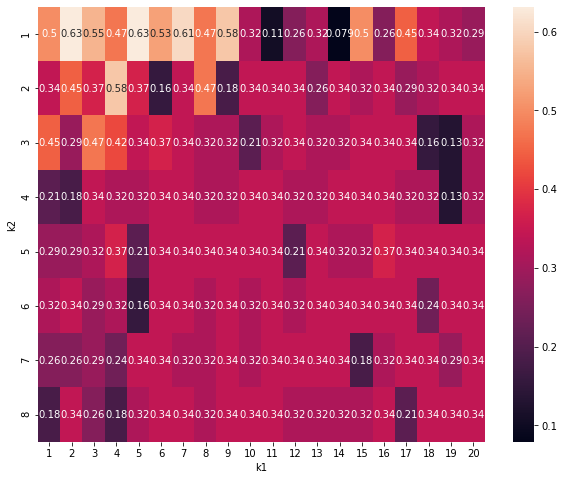

In [271]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(pivotB1, annot=True, ax=ax)

### Model C

In [272]:
%%time 
%%capture C80
perA = 0.8
d = 4
N_A = int(len(X_train)* perA)
N_B = len(X_train) - N_A
scoresC = []
k1C, k2C = [k+1 for k in range(0,20)], [k+1 for k in range(0,8)]
for k2 in k2C: 
    score = []
    for k1 in k1C:
        coef = ((N_B*k1)/(N_A*k2))**(2/d)
        score.append(knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds, coef = coef))
    scoresC.append(score)
pivotC = pd.DataFrame(scoresC, columns=k1C, index=k2C)
pivotC.index.name, pivotC.columns.name = "k2", "k1"

CPU times: user 9.58 s, sys: 65.3 ms, total: 9.65 s
Wall time: 9.74 s


<AxesSubplot:xlabel='k1', ylabel='k2'>

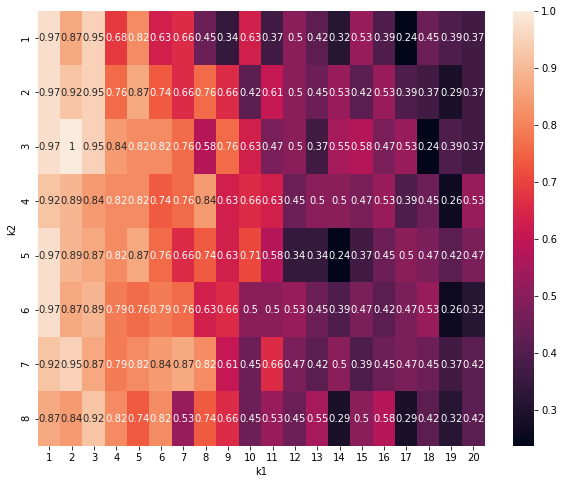

In [273]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(pivotC, annot=True, ax=ax)

In [274]:
print("Accuracy: ")
print(max(scoresA), max(map(max, scoresB1)), max(map(max, scoresC)))

Accuracy: 
0.9428571428571428 0.631578947368421 1.0


## 50% labelled

In [275]:
%%time 
%%capture B50
k1B, k2B = [k+1 for k in range(0,19)], [k+1 for k in range(20)]
perA = 0.5
scoresB2 = []
for k2 in k2B: 
    score = []
    for k1 in k1B:
        score.append(knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds))
    scoresB2.append(score)
pivotB2 = pd.DataFrame(scoresB2, columns=k1B, index=k2B)

CPU times: user 30 s, sys: 188 ms, total: 30.2 s
Wall time: 30.5 s


<AxesSubplot:xlabel='k1', ylabel='k2'>

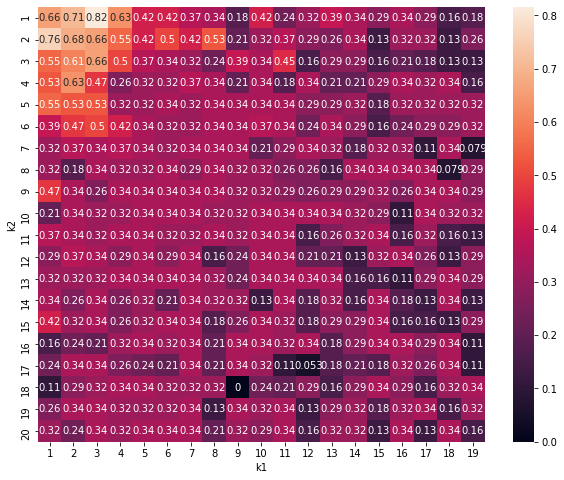

In [276]:
pivotB2.index.name, pivotB2.columns.name = "k2", "k1"
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(pivotB2, annot=True, ax=ax)

In [277]:
%%time 
%%capture C50
perA = 0.5
d = 4
N_A = int(len(X_train)* perA)
N_B = len(X_train) - N_A
scoresC2 = []
k1C, k2C = [k+1 for k in range(0,19)], [k+1 for k in range(0,20)]
for k2 in k2C: 
    score = []
    for k1 in k1C:
        coef = ((N_B*k1)/(N_A*k2))**(2/d)
        score.append(knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds, coef = coef))
    scoresC2.append(score)
pivotC2 = pd.DataFrame(scoresC2, columns=k1C, index=k2C)
pivotC2.index.name, pivotC2.columns.name = "k2", "k1"

CPU times: user 31.3 s, sys: 166 ms, total: 31.5 s
Wall time: 31.8 s


<AxesSubplot:xlabel='k1', ylabel='k2'>

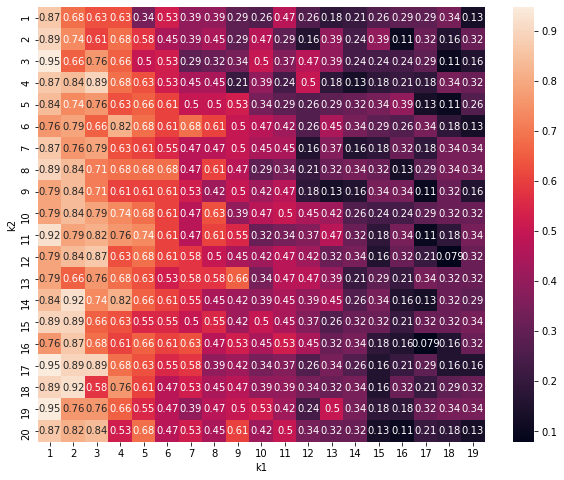

In [278]:
pivotC2.index.name, pivotC2.columns.name = "k2", "k1"
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(pivotC2, annot=True, ax=ax)

In [279]:
print("Accuracy: ")
print(max(scoresA), max(map(max, scoresB2)), max(map(max, scoresC2)))

Accuracy: 
0.9428571428571428 0.8157894736842105 0.9473684210526315


## Leave one out CV, 80% labelled

In [318]:
%%time 
%%capture B802

numFolds = len(X_train)
k1B, k2B = [k+1 for k in range(0,20)], [k+1 for k in range(8)]
perA = 0.8
scoresB3 = []
for k2 in k2B: 
    score = []
    for k1 in k1B:
        score.append(knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds))
    scoresB3.append(score)
pivotB3 = pd.DataFrame(scoresB3, columns=k1B, index=k2B)
pivotB3.index.name, pivotB3.columns.name = "k2", "k1"
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(pivotB3, annot=True, ax=ax)

CPU times: user 10.1 s, sys: 456 ms, total: 10.6 s
Wall time: 10.6 s


In [319]:
%%time 
%%capture C802

numFolds = len(X_train)
perA = 0.8
d = 4
N_A = int(len(X_train)* perA)
N_B = len(X_train) - N_A
scoresC3 = []
k1C, k2C = [k+1 for k in range(0,20)], [k+1 for k in range(8)]
for k2 in k2C: 
    score = []
    for k1 in k1C:
        coef = ((N_B*k1)/(N_A*k2))**(2/d)
        score.append(knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds, coef = coef))
    scoresC3.append(score)
pivotC3 = pd.DataFrame(scoresC3, columns=k1C, index=k2C)
pivotC3.index.name, pivotC3.columns.name = "k2", "k1"
# fig, ax = plt.subplots(1,1, figsize=(10,8))
# sns.heatmap(pivotC3, annot=True, ax=ax)

CPU times: user 10.1 s, sys: 58.7 ms, total: 10.1 s
Wall time: 10.2 s


<AxesSubplot:xlabel='k1', ylabel='k2'>

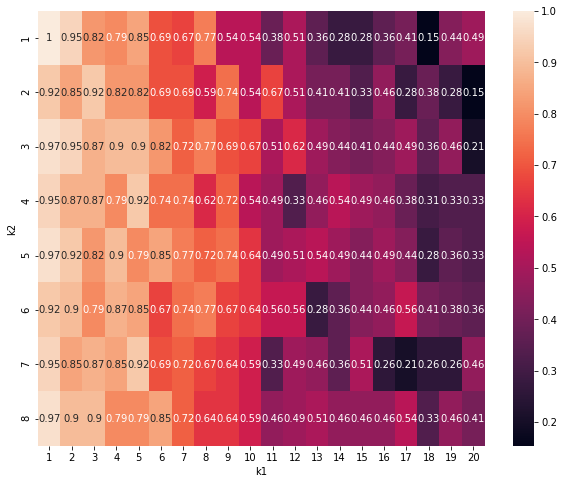

In [320]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(pivotC3, annot=True, ax=ax)

In [354]:
%%time 
%%capture C802

numFolds = len(X_train)
perA = 0.7
d = 4
N_A = int(len(X_train)* perA)
N_B = len(X_train) - N_A
scoresC4 = []
k1C, k2C = [k+1 for k in range(0,20)], [k+1 for k in range(8)]
for k2 in k2C: 
    score = []
    for k1 in k1C:
        coef = ((N_B*k1)/(N_A*k2))**(2/d)
        score.append(knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds, coef = coef))
    scoresC4.append(score)
pivotC4 = pd.DataFrame(scoresC4, columns=k1C, index=k2C)
pivotC4.index.name, pivotC4.columns.name = "k2", "k1"
# fig, ax = plt.subplots(1,1, figsize=(10,8))
# sns.heatmap(pivotC4, annot=True, ax=ax)

CPU times: user 12 s, sys: 62.3 ms, total: 12.1 s
Wall time: 12.2 s


<AxesSubplot:xlabel='k1', ylabel='k2'>

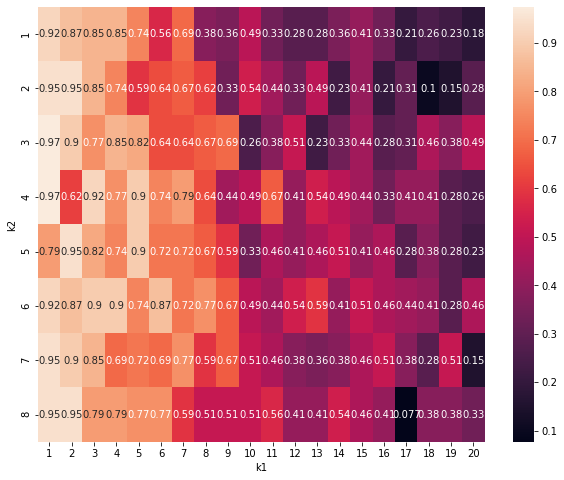

In [355]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(pivotC4, annot=True, ax=ax)

In [361]:
print("Accuracy ")
print("Full labelled data: ", max(scoresA2))
print("80%% labelled data, model B: ", max(map(max, scoresB3)))
print("80%% labelled data, model C: ", max(map(max, scoresC3)))
print("70%% labelled data, model C: ", max(map(max, scoresC4)))
# print(max(scoresA2), max(map(max, scoresB3)), max(map(max, scoresC3)), max(map(max, scoresC4)))

Accuracy 
Full labelled data:  0.9743589743589743
80%% labelled data, model B:  0.7435897435897436
80%% labelled data, model C:  1.0
70%% labelled data, model C:  0.9743589743589743


## Leave on out CV, 50% labelled

In [322]:
%%time 
%%capture B502

numFolds = len(X_train)
k1B, k2B = [k+1 for k in range(0,19)], [k+1 for k in range(20)]
perA = 0.5
scoresB4 = []
for k2 in k2B: 
    score = []
    for k1 in k1B:
        score.append(knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds))
    scoresB4.append(score)
pivotB4 = pd.DataFrame(scoresB4, columns=k1B, index=k2B)
pivotB4.index.name, pivotB4.columns.name = "k2", "k1"


CPU times: user 33.1 s, sys: 207 ms, total: 33.3 s
Wall time: 33.7 s


<AxesSubplot:xlabel='k1', ylabel='k2'>

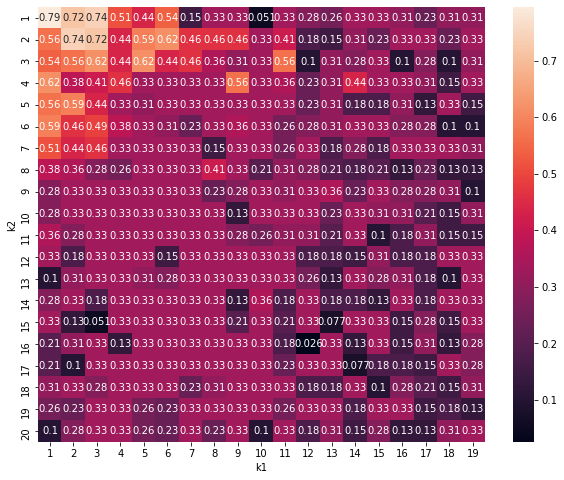

In [323]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(pivotB4, annot=True, ax=ax)

In [324]:
%%time 
%%capture C502

numFolds = len(X_train)
perA = 0.5
d = 4
N_A = int(len(X_train)* perA)
N_B = len(X_train) - N_A
scoresC4 = []
k1C, k2C = [k+1 for k in range(0,19)], [k+1 for k in range(20)]
for k2 in k2C: 
    score = []
    for k1 in k1C:
        coef = ((N_B*k1)/(N_A*k2))**(2/d)
        score.append(knn.kFCVEvaluateBC(X_train, y_train, perA, k1,k2,numFolds, coef = coef))
    scoresC4.append(score)
pivotC4 = pd.DataFrame(scoresC4, columns=k1C, index=k2C)
pivotC4.index.name, pivotC.columns.name = "k2", "k1"


CPU times: user 34.3 s, sys: 187 ms, total: 34.4 s
Wall time: 34.7 s


<AxesSubplot:ylabel='k2'>

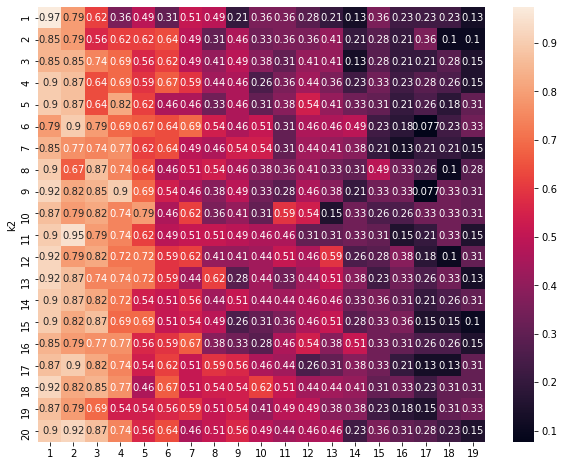

In [325]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(pivotC4, annot=True, ax=ax)

In [326]:
print("Accuracy: ")
print(max(scoresA2), max(map(max, scoresB4)), max(map(max, scoresC4)))

Accuracy: 
0.9743589743589743 0.7948717948717948 0.9743589743589743


## Prediction

In [149]:
perA = 0.5
d = 4
N_A = int(len(X_train)* perA)
N_B = len(X_train) - N_A
print(N_A,N_B)

20 21


In [60]:
from sklearn.metrics import accuracy_score
perA_B = 0.61
N_A = int(len(X_train)* perA_B)
N_B = len(X_train) - N_A
k1B,k2B = 2,1
X_A, X_B, y_A, _ = train_test_split(X_train, y_train, test_size=1-perA_B, random_state=86, stratify=y_train) #96
predB = knn.knn_B(k1B, k2B, X_A, y_A, X_B, X_test)
print("Model B classification accuracy = %.4f" % accuracy_score(predB, y_test))


perA_C = 0.77
d = 4
k1C,k2C = 1,6
N_A = int(len(X_train)* perA_C)
N_B = len(X_train) - N_A
k1B,k2B = 2,1
coef = ((N_B*k1C)/(N_A*k2C))**(2/d)
X_A, X_B, y_A, _ = train_test_split(X_train, y_train, test_size=1-perA_C, random_state=862, stratify=y_train) #96
predC = knn.knn_C(coef, k1C, k2C, X_A, y_A, X_B, X_test)
print("Model C classification accuracy = %.4f" % accuracy_score(predC, y_test))


predA = knn.find_best_label(knn.assign_unlabelled(X_train,y_train,X_test,1))
print("Model A classification accuracy = %.4f" % accuracy_score(predA, y_test))
unique, counts = np.unique(predA, return_counts=True)
print("Model A prediction count: ", dict(zip(map(int,unique), counts)))

unique, counts = np.unique(predB, return_counts=True)
print("Model B prediction count: ", dict(zip(map(int,unique), counts)))

unique, counts = np.unique(predC, return_counts=True)
print("Model C prediction count: ", dict(zip(map(int,unique), counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Real count: ", dict(zip(map(int,unique), counts)))


Model B classification accuracy = 0.8000
Model C classification accuracy = 0.9500
Model A classification accuracy = 0.9000
Model A prediction count:  {1: 8, 2: 2, 3: 4, 4: 6}
Model B prediction count:  {1: 6, 2: 2, 3: 8, 4: 4}
Model C prediction count:  {1: 7, 2: 2, 3: 5, 4: 6}
Real count:  {1: 7, 2: 2, 3: 6, 4: 5}
